In [999]:
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import numpy as np
from sklearn.model_selection import train_test_split

import librosa 
from librosa import feature
import soundfile
import os, glob, pickle
import re #split strings

from sklearn import preprocessing

fn_list_i = [
 feature.chroma_stft,
 feature.spectral_centroid,
 feature.spectral_bandwidth,
 feature.spectral_rolloff
]
 
fn_list_ii = [
 feature.zero_crossing_rate
]
#feature.rmse,

emotions={
    0:'neutral',
    1:'calm',
    2:'happy',
    3:'sad',
    4:'angry',
    5:'fearful',
    6:'disgust',
    7:'surprised'
}

# Not stressed: happy(2), calm(1).
# Stressed:     sad(3), fearful(5)
stress_emotions = {
    1:0,
    2:0,
    3:1,
    5:1
}
selected_emotions = {1,2,3,5}

In [1059]:
#preprocesamiento de corpus
def preprocessing_data(filename):
    # 1) audio: mono 
    # 2) frecuencia de muestreo(SR): 16000Hz
    data, sr = librosa.load(filename, sr=16000, mono=True)
    #3) normalizacion
    X_scale = preprocessing.normalize([data])[0]
    #plot_data(normalizado, sr)
    #TODO: otros: farming, windowing, Voice Activity Detector (VAD), noise reduction,
    return [X_scale, sr]


In [1060]:

def get_feature_vector(X_file_data,sample_rate): 
    result = np.array([])
  
    stft = np.abs(librosa.stft(X_file_data))
    
    #mfcc
    mfccs = np.mean(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=60).T, axis=0)
    result = np.hstack((result, mfccs))#concatena ([1,2][3,4]) => [1,2,3,4]

    mfccs_var = np.var(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=60).T, axis=0)
    result = np.hstack((result, mfccs_var)) 

    mfccs_std = np.std(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=60).T, axis=0)
    result = np.hstack((result, mfccs_std)) 
    
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result = np.hstack((result, chroma))
    
    mel = np.mean(librosa.feature.melspectrogram(X_file_data, sr=sample_rate).T,axis=0)
    result = np.hstack((result, mel))
    
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    result = np.hstack((result, contrast))
    
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X_file_data), sr=sample_rate).T,axis=0)
    result = np.hstack((result, tonnetz))
    

    return result

In [1061]:
def load_data():
    x,y=[],[]
    for file in glob.glob("/media/yonel/730D-8298/DATASETS/RAVDESS/Actor_*/*.wav"): #* PC
        file_name = os.path.basename(file) #            03-01-01-01-01-01-01.wav
        print('Progress:  %s' % (file_name), end='\r')
        file_name_no_type = file_name.split(".")[0] #   03-01-01-01-01-01-01
        list_emotions = file_name_no_type.split("-") #  ['03', '01', '01', '01', '01', '01', '01']
        emotion = int(list_emotions[2])-1 #iniciar contador de emociones desde 0 a 7 (8emociones)
        
        if emotion in selected_emotions:
            emotion = stress_emotions[emotion]       
            signal, sample_rate = preprocessing_data(file)
            features = get_feature_vector(signal,sample_rate)
            x.append(features)
            y.append(emotion)

    return np.array(x), np.array(y)

In [1062]:
X_data,Y_data = load_data()
print("\n")
print("X_data:", X_data.shape, "Y_data:",  Y_data.shape)

Progress:  03-01-08-02-02-02-24.wav

X_data: (768, 333) Y_data: (768,)


In [1487]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X_data)
Y = Y_data 
print("X_data:", X.shape, "Y_data:",  Y.shape)

X_data: (768, 333) Y_data: (768,)


In [1488]:
from sklearn.decomposition import PCA
X =  PCA(n_components=300).fit_transform(X)
print("X_data:", X.shape, "Y_data:",  Y.shape)


X_data: (768, 300) Y_data: (768,)


No estresados: 384 | Estresados: 384


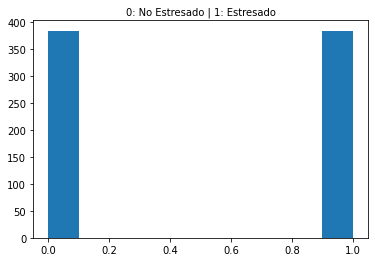

In [1518]:
estresados = Y.sum()
no_estresados = Y.shape[0]-estresados
print("No estresados:",no_estresados, "| Estresados:", estresados)


import matplotlib.pyplot as plt

data = Y
plt.hist(data)
plt.title('0: No Estresado | 1: Estresado', fontsize=10)
#plt.savefig("Estres_NoEstres.png")
plt.show()

### división de datos: Entrenamiento, validación y prueba

In [1519]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=10) 
print("Entrenamiento:", X_train.shape, Y_train.shape, "Prueba:", X_test.shape, Y_test.shape)

Entrenamiento: (537, 300) (537,) Prueba: (231, 300) (231,)


In [1520]:
from keras import metrics
import math

model = Sequential([ 
    Dense(350, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(40, activation='relu'),
    Dense(2, activation="softmax")
])


initial_learning_rate = 0.01

def lr_exp_decay(epoch, lr):
    k = 0.05
    return initial_learning_rate * math.exp(-k*epoch)


opt = keras.optimizers.RMSprop(learning_rate=initial_learning_rate)


mts = keras.metrics.SparseCategoricalAccuracy(name="acc")
model.compile(optimizer = opt, loss="sparse_categorical_crossentropy", metrics= [mts])

In [1521]:
from keras.callbacks import LearningRateScheduler

history = model.fit(X_train, Y_train, 
                    batch_size=20, 
                    epochs=50 , 
                    callbacks=[LearningRateScheduler(lr_exp_decay, verbose=1)])


Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
27/27 [==============================] - 1s 5ms/step - loss: 0.7320 - acc: 0.5927
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00951229424500714.
27/27 [==============================] - 0s 5ms/step - loss: 0.2982 - acc: 0.8875
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.009048374180359595.
27/27 [==============================] - 0s 5ms/step - loss: 0.1174 - acc: 0.9427
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.008607079764250578.
27/27 [==============================] - 0s 5ms/step - loss: 0.0397 - acc: 0.9837
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.008187307530779819.
27/27 [==============================] - 0s 6ms/step - loss: 0.0070 - acc: 0.9985
Epoch 6/50

Epoch 00006: LearningRateScheduler reducing learning rate to 0.007788007830714049.
27/27 [==============================

27/27 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 47/50

Epoch 00047: LearningRateScheduler reducing learning rate to 0.001002588437228037.
27/27 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 48/50

Epoch 00048: LearningRateScheduler reducing learning rate to 0.0009536916221554962.
27/27 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 49/50

Epoch 00049: LearningRateScheduler reducing learning rate to 0.0009071795328941247.
27/27 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 1.0000
Epoch 50/50

Epoch 00050: LearningRateScheduler reducing learning rate to 0.0008629358649937049.
27/27 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - acc: 1.0000


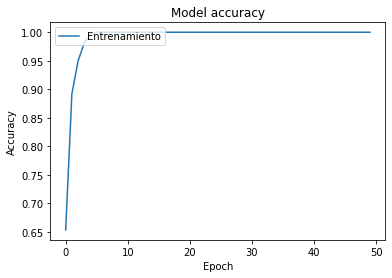

In [1522]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc']) #accuracy
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'validacion'], loc='upper left')
plt.show()

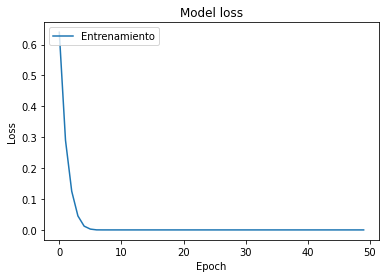

In [1523]:
#plot perdida
plt.plot(history.history['loss']) 
#plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Entrenamiento', 'validacion'], loc='upper left') 
plt.show()

In [1524]:
from sklearn.metrics import classification_report
# precision, recall, score, accuracy
# print(model.evaluate(X_test,Y_test)[1]*100,"%") #[0] perdida, [1] presicion

y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(Y_test, y_pred_bool))


              precision    recall  f1-score   support

           0       0.82      0.85      0.84       114
           1       0.85      0.82      0.83       117

    accuracy                           0.84       231
   macro avg       0.84      0.84      0.84       231
weighted avg       0.84      0.84      0.84       231



### save model

In [1525]:
model.save('model.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
new_model = keras.models.load_model('model.h5')
# Prueba
print("Exactitud")
print(new_model.evaluate(X_test,Y_test)[1],"%") #[0] perdida, [1] presicion

Exactitud
8/8 [==============================] - 0s 3ms/step - loss: 1.5959 - acc: 0.8355
0.8354978561401367 %


In [1526]:
predictions = new_model.predict(X_test)
print(predictions)

# Generate arg maxes for predictions
classes = np.argmax(predictions, axis = 1)
print(classes)

[[1.28582920e-04 9.99871373e-01]
 [6.84755445e-02 9.31524456e-01]
 [9.99979138e-01 2.08128586e-05]
 [9.99995589e-01 4.35224911e-06]
 [9.99316335e-01 6.83625811e-04]
 [3.42032319e-10 1.00000000e+00]
 [2.64380002e-08 1.00000000e+00]
 [1.00000000e+00 9.77402075e-15]
 [5.63271788e-05 9.99943614e-01]
 [5.56975374e-06 9.99994397e-01]
 [1.00000000e+00 3.71684961e-10]
 [1.00000000e+00 2.49029658e-10]
 [1.00000000e+00 1.03026014e-16]
 [9.99999046e-01 1.00343129e-06]
 [6.02829386e-05 9.99939680e-01]
 [1.46276749e-13 1.00000000e+00]
 [1.00000000e+00 7.28816159e-16]
 [1.62303515e-09 1.00000000e+00]
 [8.15155602e-07 9.99999166e-01]
 [1.00000000e+00 2.00479715e-12]
 [9.99877810e-01 1.22174824e-04]
 [8.80370440e-04 9.99119580e-01]
 [9.99999046e-01 9.47732076e-07]
 [2.74601678e-14 1.00000000e+00]
 [9.33423936e-01 6.65760934e-02]
 [1.00000000e+00 4.29609415e-08]
 [1.21767789e-05 9.99987841e-01]
 [9.99199092e-01 8.00935377e-04]
 [1.47547172e-02 9.85245287e-01]
 [1.00000000e+00 8.34898272e-21]
 [2.918781